# Demo LoFTR-DS on a single pair of images

This notebook shows how to use the loftr matcher with default config(dual-softmax) and the pretrained weights.

In [1]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

In [2]:
os.getcwd()

'/home/cvte-vm/Deep_Feature_Extract/LoFTR'

## Indoor Example

In [25]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
_default_cfg['match_coarse']['thr'] = 0.2
matcher = LoFTR(config=_default_cfg)
#matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher.load_state_dict(torch.load("weights/indoor_ds_new.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [5]:
matcher

LoFTR(
  (backbone): ResNetFPN_8_2(
    (conv1): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [3]:
_default_cfg

{'backbone_type': 'ResNetFPN',
 'resolution': (8, 2),
 'fine_window_size': 5,
 'fine_concat_coarse_feat': True,
 'resnetfpn': {'initial_dim': 128, 'block_dims': [128, 196, 256]},
 'coarse': {'d_model': 256,
  'd_ffn': 256,
  'nhead': 8,
  'layer_names': ['self',
   'cross',
   'self',
   'cross',
   'self',
   'cross',
   'self',
   'cross'],
  'attention': 'linear',
  'temp_bug_fix': True},
 'match_coarse': {'thr': 0.2,
  'border_rm': 2,
  'match_type': 'dual_softmax',
  'dsmax_temperature': 0.1,
  'skh_iters': 3,
  'skh_init_bin_score': 1.0,
  'skh_prefilter': True,
  'train_coarse_percent': 0.4,
  'train_pad_num_gt_min': 200},
 'fine': {'d_model': 128,
  'd_ffn': 128,
  'nhead': 8,
  'layer_names': ['self', 'cross'],
  'attention': 'linear'}}

In [32]:
# Load example images
img0_pth = "/home/cvte-vm/Datasets/HPatches/hpatches-sequences-release/v_bark/1.ppm"
img1_pth = "/home/cvte-vm/Datasets/HPatches/hpatches-sequences-release/v_bark/3.ppm"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

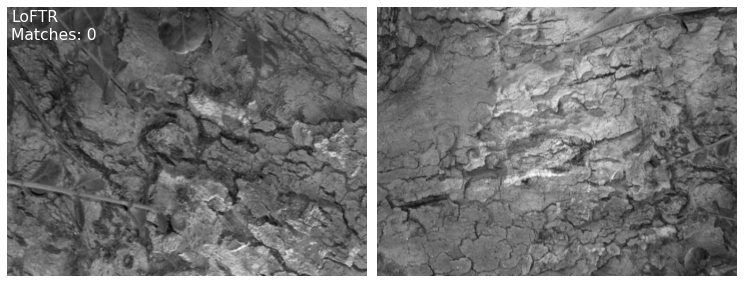

In [33]:
    color = cm.jet(mconf)
    text = [
        'LoFTR',
        'Matches: {}'.format(len(mkpts0)),
    ]
    fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

In [7]:
batch

{'image0': tensor([[[[0.1843, 0.8980, 1.0000,  ..., 0.3608, 0.3608, 0.3608],
           [0.1647, 0.8784, 1.0000,  ..., 0.3569, 0.3569, 0.3569],
           [0.1451, 0.8627, 1.0000,  ..., 0.3569, 0.3569, 0.3569],
           ...,
           [0.1059, 0.4000, 0.4000,  ..., 0.3843, 0.3843, 0.3843],
           [0.1020, 0.3725, 0.3255,  ..., 0.3882, 0.3882, 0.3882],
           [0.1059, 0.3451, 0.2627,  ..., 0.3882, 0.3882, 0.3882]]]],
        device='cuda:0'),
 'image1': tensor([[[[0.0549, 0.2039, 0.2353,  ..., 0.2039, 0.2000, 0.2000],
           [0.0549, 0.2039, 0.2275,  ..., 0.1961, 0.1961, 0.1922],
           [0.0510, 0.2000, 0.2235,  ..., 0.2000, 0.1961, 0.1961],
           ...,
           [0.0902, 0.3412, 0.3412,  ..., 0.4196, 0.4196, 0.4196],
           [0.1020, 0.4314, 0.4667,  ..., 0.4196, 0.4157, 0.4196],
           [0.1059, 0.4431, 0.4902,  ..., 0.4196, 0.4196, 0.4157]]]],
        device='cuda:0'),
 'bs': 1,
 'hw0_i': torch.Size([480, 640]),
 'hw1_i': torch.Size([480, 640]),
 'hw0_c'

In [20]:
batch['image0'].shape

torch.Size([1, 1, 480, 640])

In [9]:
batch['conf_matrix'].shape  
#the first number 4800 comes from 60*80 of the first image
#the second number 4800 comes from the 60*80 of the second image

torch.Size([1, 4800, 4800])

In [15]:
batch['i_ids'].shape

torch.Size([338])

In [16]:
batch['j_ids'].shape

torch.Size([338])

In [21]:
batch['hw0_i']

torch.Size([480, 640])

In [22]:
batch['bs']

1

In [23]:
batch['mask0']

KeyError: 'mask0'

In [25]:
batch['data0']

KeyError: 'data0'

In [26]:
batch['spv_b_ids']

KeyError: 'spv_b_ids'

In [27]:
batch['scale1']

KeyError: 'scale1'

In [6]:
mkpts0

array([[344., 168.]], dtype=float32)

## Outdoor Example

In [16]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [19]:
default_cfg['coarse']

{'d_model': 256,
 'd_ffn': 256,
 'nhead': 8,
 'layer_names': ['self',
  'cross',
  'self',
  'cross',
  'self',
  'cross',
  'self',
  'cross'],
 'attention': 'linear',
 'temp_bug_fix': True}

In [17]:
# Load example images
img0_pth = "assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

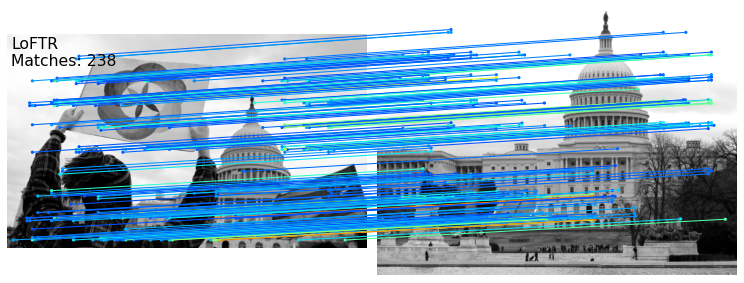

In [18]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)